In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns


In [2]:
# Load your CSV file
data = pd.read_excel('data.xlsx')  # Replace with your actual filename

# Generating features 

In [3]:
resolution_m = 60e-6 #m
resolution_cm = 60e-4 #cm
sample_size_pixel = 400
sample_length_cm = resolution_cm * sample_size_pixel

data['cluster_density'] = data['num_cluster'] / (sample_length_cm**3)
data['anisotropy_MIL'] = (data['MIL_x'] + data['MIL_y']) / (2*data['MIL_z'])
data['anisotropy_Perm'] = (data['Perm_x'] + data['Perm_y']) / (2*data['Perm_z'])
data['anisotropy_Tort'] = (data['Tort_x'] + data['Tort_y']) / (2*data['Tort_z'])
data['avg_pore_diameter'] = data['avg_pore_diameter'] * 1e6
data['avg_throat_diameter'] = data['avg_throat_diameter'] * 1e6
data['density'] = (1- (data['porosity']/100)) * 0.917 # density g/cm3
data.columns

Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'anisotropy_MIL', 'anisotropy_Perm',
       'anisotropy_Tort', 'density'],
      dtype='object')

# Permeability and Tortuosity feature correlation

In [79]:
df_fit = data[data["new_depth"]<60].copy()

df_fit = df_fit.drop(columns = ['name', 'number_of_regions', 'starting_layer', 'ending_layer','depth','sample_volume'])

df_fit = df_fit.drop(columns = ['MIL_y','MIL_x','Tort_x','Tort_y','Perm_x','Perm_y','num_cluster',
                                'max_connections','max_cluster_size','anisotropy_Perm','anisotropy_Tort'
                               ,'avg_throat_diameter','avg_pore_diameter'])

df_fit = df_fit[df_fit["Perm_z"] > 5e-12]
df_fit = df_fit[df_fit["Perm_z"] < 5e-8]

df_fit = df_fit[df_fit["Tort_z"] > 1]
df_fit = df_fit[df_fit["Tort_z"] < 150]



In [87]:
print('old column names = ',df_fit.columns)
new_columns = ['Porosity', 'Open Porosity', 'Cuted Porosity', 'Isolated Porosity',
       'Euler Density', 'SSA', 'MIL', 'Permeability', 'Tortuosity', 'Spherical Ice Cluster',
       'Num Pores', 'Num Throats', 'Coordination Num',
       'SD Coordination Num', 'Mean Pore Volume', 'Mean Throat Length',
       'Median Num Connections', 'Mean Cluster Size', 'Mean Pore Surface Area',
       'Mean Throat Area', 'Depth', 'Cluster Density', 'Anisotropy MIL',
       'Density']
# Compute the correlation matrix
df_fit.columns = new_columns
corr_matrix = df_fit.corr()
corr_matrix

old column names =  Index(['Porosity', 'Open Porosity', 'Cuted Porosity', 'Isolated Porosity',
       'Euler Density', 'SSA', 'MIL', 'Permeability', 'Tortuosity',
       'Spherical Ice Cluster', 'Num Pores', 'Num Throats',
       'Coordination Number', 'SD Coordination Number', 'Mean Pore Volume',
       'Mean Throat Length', 'Median Num Connections', 'Mean Cluster Size',
       'Mean Pore Surface Area', 'Mean Throat Area', 'Depth',
       'Cluster Density', 'Anisotropy MIL', 'Density'],
      dtype='object')


Porosity  Open Porosity  Cuted Porosity  \
Porosity                1.000000       0.999978       -0.581848   
Open Porosity           0.999978       1.000000       -0.587153   
Cuted Porosity         -0.581848      -0.587153        1.000000   
Isolated Porosity      -0.486648      -0.492218        0.919711   
Euler Density          -0.617624      -0.619128        0.540507   
SSA                     0.829676       0.830808       -0.620443   
MIL                    -0.946821      -0.948088        0.712884   
Permeability            0.820882       0.819905       -0.355739   
Tortuosity             -0.734783      -0.738640        0.897226   
Spherical Ice Cluster  -0.931770      -0.932189        0.589498   
Num Pores               0.641321       0.641179       -0.342033   
Num Throats             0.823115       0.822768       -0.425961   
Coordination Num        0.994305       0.994463       -0.598470   
SD Coordination Num     0.993107       0.993025       -0.574658   
Mean Pore Volume        0.694277       0.694592       -0.463416   
Mean Throat Length      0.507272       0.508221       -0.439953   
Median Num Connections  0.951752       0.951767       -0.553479   
Mean Cluster Size       0.724224       0.724152       -0.403059   
Mean Pore Surface Area  0.544165       0.545122       -0.459709   
Mean Throat Area        0.691693       0.692033       -0.468384   
Depth                  -0.961785      -0.962440        0.650676   
Cluster Density        -0.702059      -0.705777        0.831567   
Anisotropy MIL         -0.710706      -0.710146        0.327252   
Density                -1.000000      -0.999978        0.581848   

                        Isolated Porosity  Euler Density       SSA       MIL  \
Porosity                        -0.486648      -0.617624  0.829676 -0.946821   
Open Porosity                   -0.492218      -0.619128  0.830808 -0.948088   
Cuted Porosity                   0.919711       0.540507 -0.620443  0.712884   
Isolated Porosity                1.000000       0.492587 -0.548985  0.611244   
Euler Density                    0.492587       1.000000 -0.933701  0.773891   
SSA                             -0.548985      -0.933701  1.000000 -0.931831   
MIL                              0.611244       0.773891 -0.931831  1.000000   
Permeability                    -0.290206      -0.261774  0.506982 -0.681386   
Tortuosity                       0.840693       0.594707 -0.720099  0.824828   
Spherical Ice Cluster            0.517460       0.818948 -0.956288  0.964538   
Num Pores                       -0.320388      -0.895341  0.873725 -0.698797   
Num Throats                     -0.380326      -0.826216  0.896280 -0.815315   
Coordination Num                -0.509301      -0.669161  0.871073 -0.959879   
SD Coordination Num             -0.469193      -0.562691  0.791861 -0.929694   
Mean Pore Volume                -0.347965      -0.031077  0.275470 -0.579835   
Mean Throat Length              -0.321221       0.132075  0.098332 -0.416339   
Median Num Connections          -0.475334      -0.648328  0.840906 -0.915883   
Mean Cluster Size               -0.363497      -0.716407  0.785922 -0.718326   
Mean Pore Surface Area          -0.344446       0.076469  0.154088 -0.462162   
Mean Throat Area                -0.344308      -0.036965  0.286945 -0.583550   
Depth                            0.536842       0.720202 -0.897882  0.980508   
Cluster Density                  0.856307       0.686092 -0.778593  0.820016   
Anisotropy MIL                   0.310924       0.408802 -0.620098  0.661184   
Density                          0.486648       0.617624 -0.829676  0.946821   

                        Permeability  Tortuosity  Spherical Ice Cluster  ...  \
Porosity                    0.820882   -0.734783              -0.931770  ...   
Open Porosity               0.819905   -0.738640              -0.932189  ...   
Cuted Porosity             -0.355739    0.897226               0.589498  ...   
Isolated Porosity          

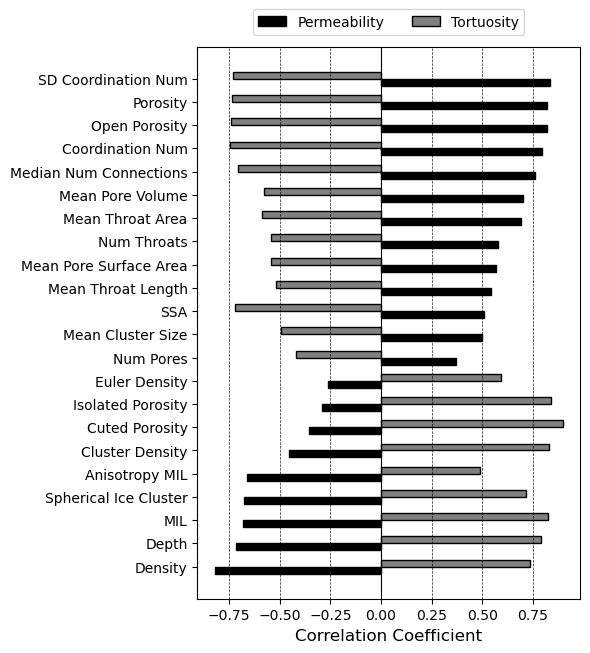

In [93]:
# Get correlations for Perm_z and Tort_z (excluding self-correlations)
features = corr_matrix.columns.drop(['Permeability', 'Tortuosity'])
perm_corr = corr_matrix.loc[features, 'Permeability']
tort_corr = corr_matrix.loc[features, 'Tortuosity']

features_sorted = perm_corr.sort_values().index
perm_sorted = perm_corr[features_sorted]
tort_sorted = tort_corr[features_sorted]


# Plotting
fig, ax = plt.subplots(figsize=(6, len(features_sorted) * 0.3))  # Portrait layout

bar_width = 0.3
indices = np.arange(len(features_sorted))

# Colorblind-safe colors
perm_color = 'black'   # Blue
tort_color = 'gray'   # Orange

# Horizontal bars
ax.barh(indices - bar_width/2, perm_sorted, height=bar_width, color=perm_color, edgecolor='black', label='Permeability')
ax.barh(indices + bar_width/2, tort_sorted, height=bar_width, color=tort_color, edgecolor='black', label='Tortuosity')

# Labels and aesthetics
ax.set_yticks(indices)
ax.set_yticklabels(features_sorted, fontsize=10,color='black')
ax.set_xlabel('Correlation Coefficient', fontsize=12)
#ax.set_title('Correlation of Features with Perm_z and Tort_z', fontsize=13)

# Gridlines and axis styling
ax.grid(axis='x', linestyle='--', color='black', linewidth=0.5, alpha=0.9)
ax.axvline(0, color='black', linewidth=0.8)
ax.tick_params(axis='x', labelsize=10)

# Legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=2, frameon=True, fontsize=10)
plt.tight_layout()
plt.savefig('correlation_perm_tort.png',dpi=300)
plt.show()

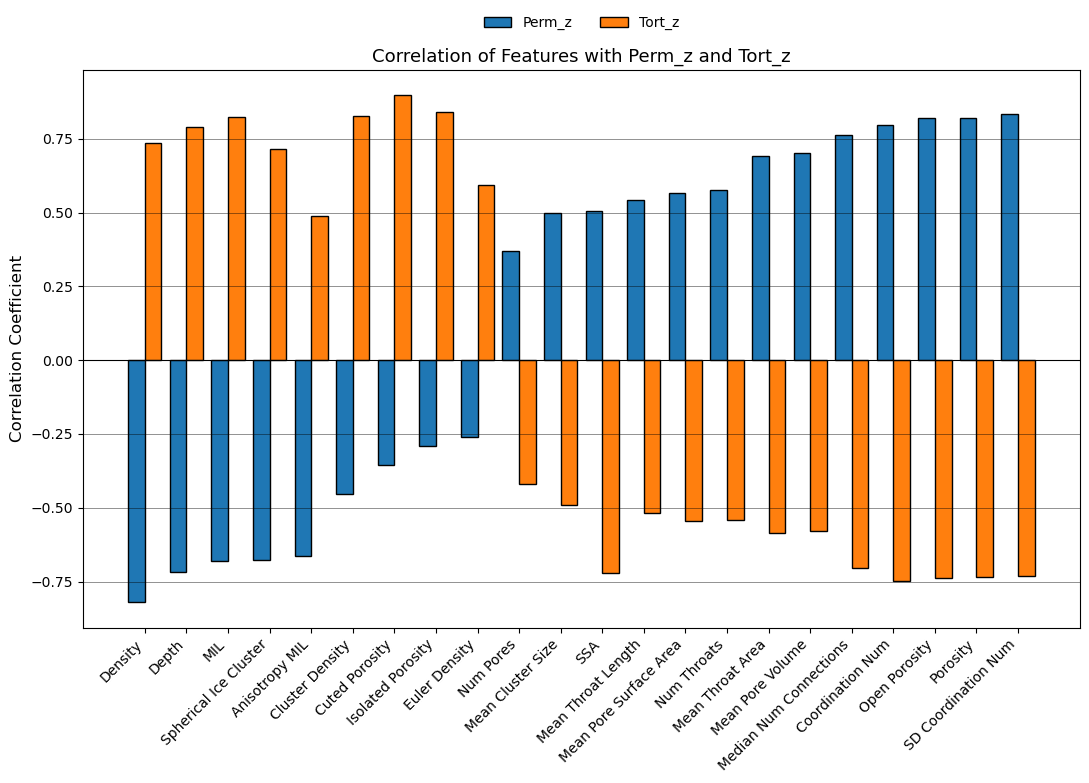

In [89]:
# Get correlations for Perm_z and Tort_z (excluding self-correlations)
features = corr_matrix.columns.drop(['Permeability', 'Tortuosity'])
perm_corr = corr_matrix.loc[features, 'Permeability']
tort_corr = corr_matrix.loc[features, 'Tortuosity']

features_sorted = perm_corr.sort_values().index
perm_sorted = perm_corr[features_sorted]
tort_sorted = tort_corr[features_sorted]



# X positions for grouped bars
x = np.arange(len(features_sorted))
bar_width = 0.4

# Colors: Colorblind-safe and academic
perm_color = '#1f77b4'   # Blue
tort_color = '#ff7f0e'   # Orange

# Plot
fig, ax = plt.subplots(figsize=(len(features_sorted) * 0.5, 8))  # Portrait layout

# Bars
ax.bar(x - bar_width/2, perm_sorted, width=bar_width, color=perm_color, edgecolor='black', label='Perm_z')
ax.bar(x + bar_width/2, tort_sorted, width=bar_width, color=tort_color, edgecolor='black', label='Tort_z')

# X-axis labels
ax.set_xticks(x)
ax.set_xticklabels(features_sorted, rotation=45, ha='right', fontsize=10)

# Labels and title
ax.set_ylabel('Correlation Coefficient', fontsize=12)
ax.set_title('Correlation of Features with Perm_z and Tort_z', fontsize=13)

# Gridlines on y-axis
ax.grid(axis='y', linestyle='-', color='black', linewidth=0.5, alpha=0.6)
ax.axhline(0, color='black', linewidth=0.8)

# Legend on top center
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=2, frameon=False, fontsize=10)

plt.tight_layout()
plt.show()

In [18]:
df_fit = data[data["new_depth"]<60].copy()
df_fit = df_fit.drop(columns = ['MIL_y','MIL_x','Tort_x','Tort_y','num_cluster', 'max_connections','max_cluster_size'
                               ,'avg_throat_diameter','avg_pore_diameter'])
df_fit = df_fit[df_fit["Perm_z"] > 5e-12]
df_fit = df_fit[df_fit["Perm_z"] < 5e-8]
df_fit = df_fit.drop(columns = ['name', 'number_of_regions', 'starting_layer', 'ending_layer','depth','sample_volume'])
# Compute the correlation matrix
corr_matrix = df_fit.corr()

In [19]:
corr_matrix['Perm_z'].sort_values()

density                   -0.820882
new_depth                 -0.717227
MIL_z                     -0.681386
sph_ice_cluster           -0.678619
anisotropy_MIL            -0.662722
Tort_z                    -0.512600
cluster_density           -0.455139
cuted_pores               -0.355739
isolated_pores            -0.290206
euler_density             -0.261774
anisotropy_Tort           -0.022147
Perm_x                     0.042348
anisotropy_Perm            0.044469
Perm_y                     0.054325
num_pores                  0.368368
avg_cluster_size           0.498027
SSA                        0.506982
avg_throat_length          0.544189
avg_pore_surface_area      0.566773
num_throats                0.576831
avg_throat_area            0.692269
avg_pore_volume            0.703372
median_connections         0.761741
coordination_number        0.796664
open_pores                 0.819905
porosity                   0.820882
std_coordination_number    0.834342
Perm_z                     1

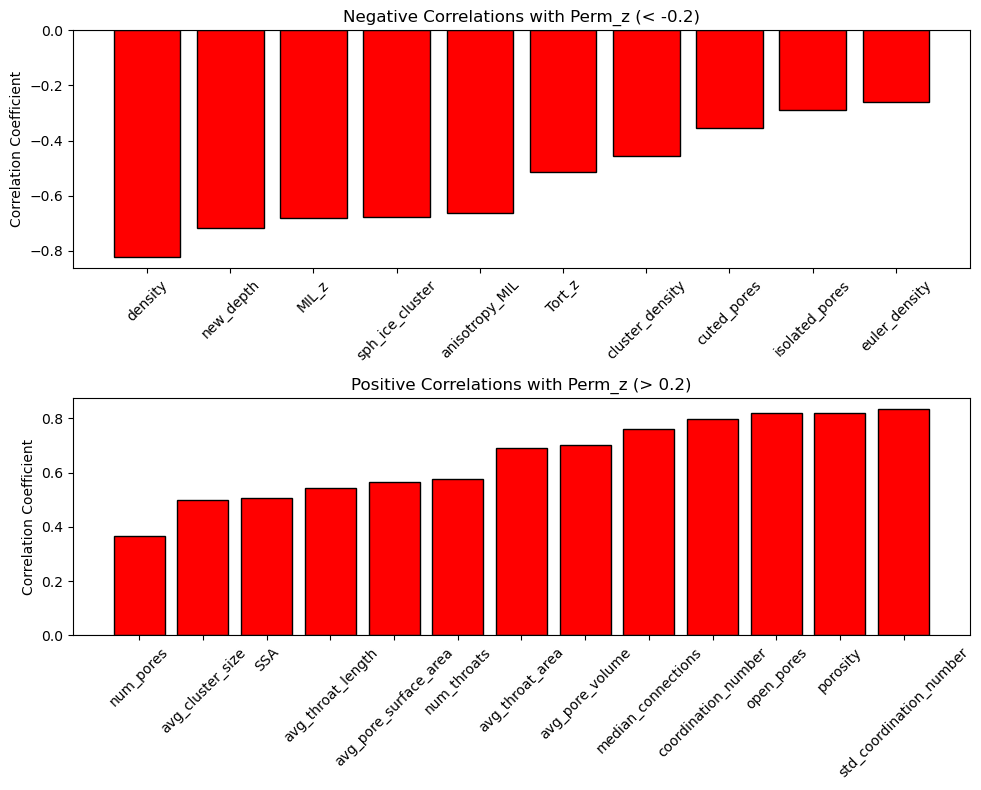

In [25]:
corr_perm = corr_matrix['Perm_z'].drop('Perm_z')  # Drop self-correlation

threshold = 0.2
neg_corr = corr_perm[corr_perm < -threshold].sort_values()
pos_corr = corr_perm[corr_perm > threshold].sort_values()

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Common bar style
bar_style = dict(color='red', edgecolor='black')

# Top: Negative correlations
ax1.bar(neg_corr.index, neg_corr.values, **bar_style)
ax1.set_title('Negative Correlations with Perm_z (< -0.2)')
ax1.axhline(0, color='gray', linewidth=0.8)
ax1.set_ylabel('Correlation Coefficient')
ax1.tick_params(axis='x', rotation=45)

# Bottom: Positive correlations
ax2.bar(pos_corr.index, pos_corr.values, **bar_style)
ax2.set_title('Positive Correlations with Perm_z (> 0.2)')
ax2.axhline(0, color='gray', linewidth=0.8)
ax2.set_ylabel('Correlation Coefficient')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [26]:
df_fit = data[data["new_depth"]<60].copy()
df_fit = df_fit.drop(columns = ['MIL_y','MIL_x','Tort_x','Tort_y','num_cluster'])
df_fit = df_fit[df_fit["Tort_z"] > 1]
df_fit = df_fit[df_fit["Tort_z"] < 150]

df_fit = df_fit.drop(columns = ['name', 'number_of_regions', 'starting_layer', 'ending_layer','depth','sample_volume'])
# Compute the correlation matrix
corr_matrix = df_fit.corr()

In [27]:
corr_matrix['Tort_z'].sort_values()

coordination_number       -0.746939
open_pores                -0.734175
porosity                  -0.730352
std_coordination_number   -0.726767
SSA                       -0.716214
median_connections        -0.704297
avg_pore_diameter         -0.646195
avg_throat_area           -0.581147
avg_pore_volume           -0.554726
num_throats               -0.541187
avg_pore_surface_area     -0.540287
avg_throat_length         -0.513728
avg_cluster_size          -0.490313
avg_throat_diameter       -0.465259
max_cluster_size          -0.451804
num_pores                 -0.419482
max_connections           -0.305186
Perm_z                    -0.041398
Perm_x                    -0.032820
anisotropy_Tort           -0.029016
Perm_y                    -0.028409
anisotropy_Perm           -0.017974
anisotropy_MIL             0.489210
euler_density              0.591607
sph_ice_cluster            0.713827
density                    0.730352
new_depth                  0.789741
MIL_z                      0

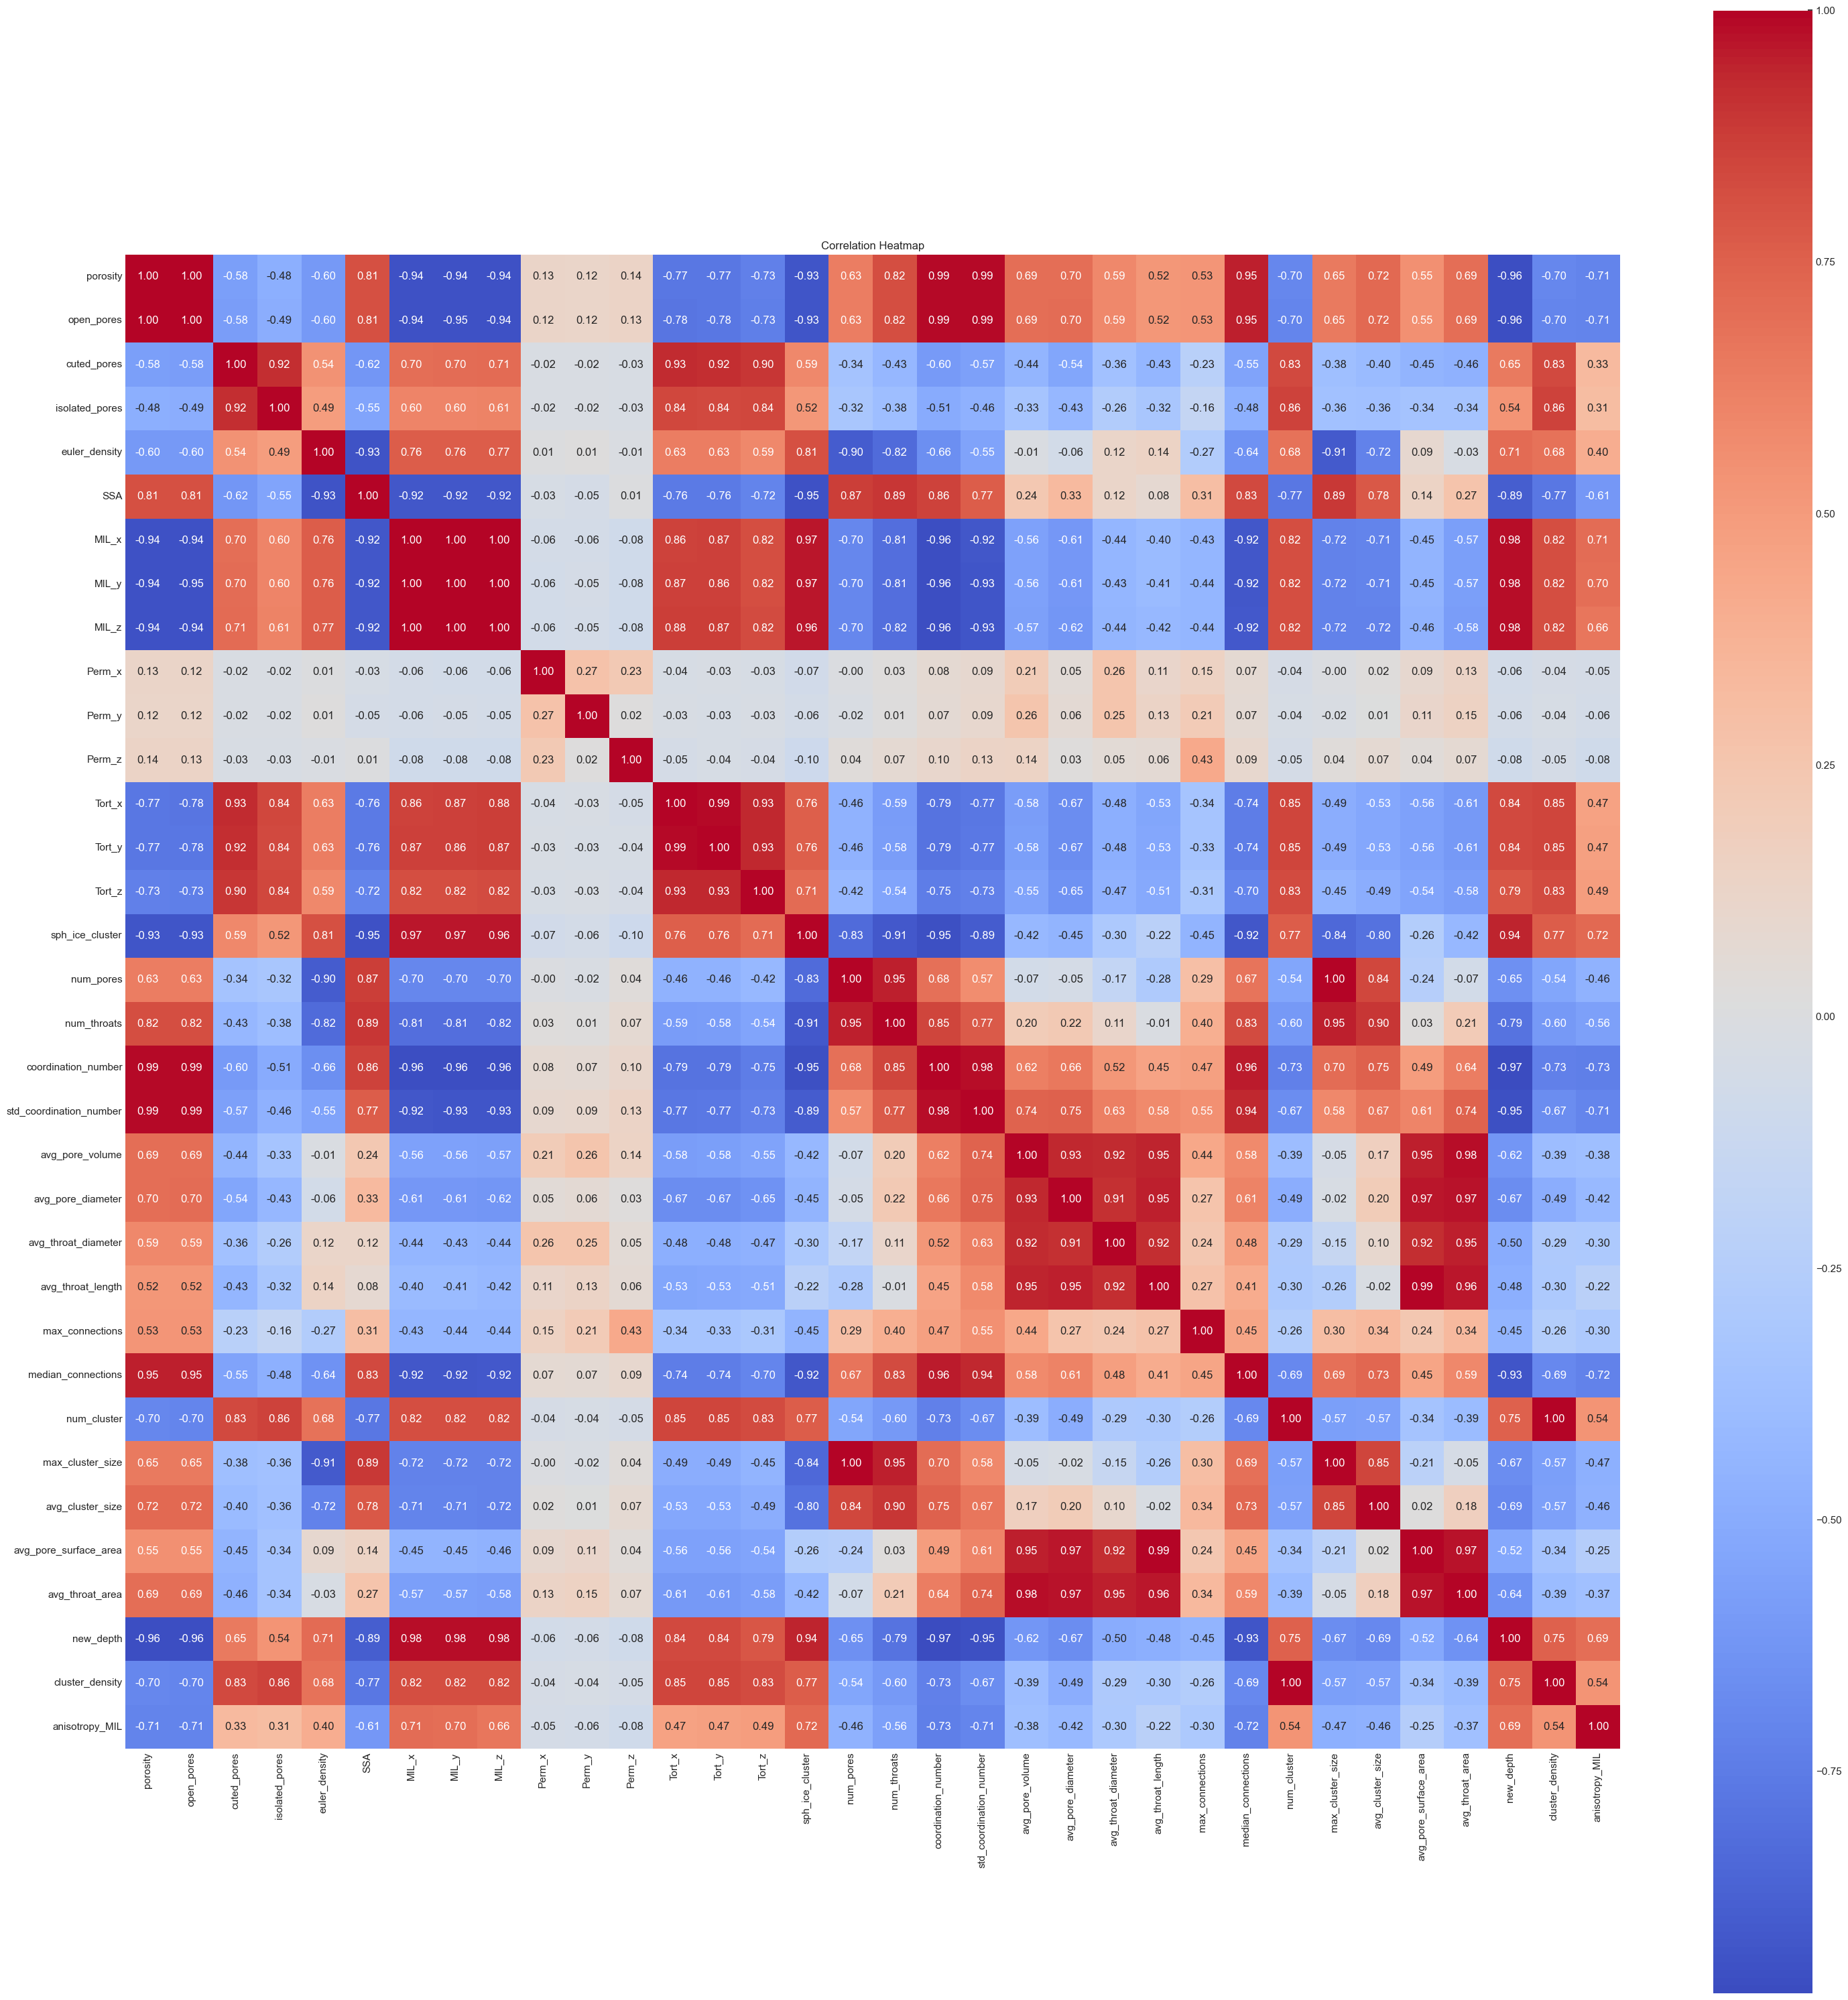

In [11]:


# Set up the matplotlib figure
plt.figure(figsize=(30, 30))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)

# Show the plot
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_1_60.png')

In [19]:
# Load dataset
df = data.copy()

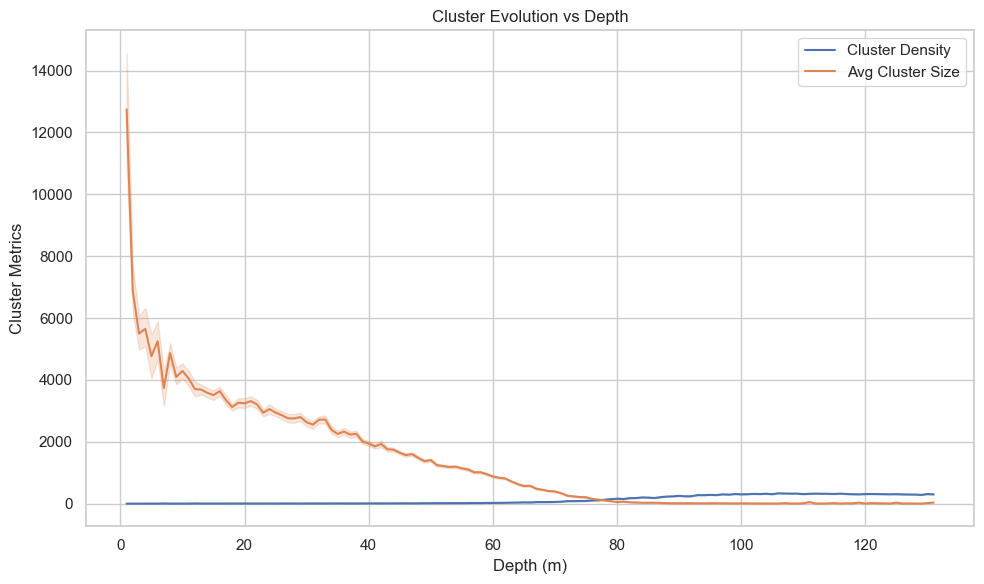

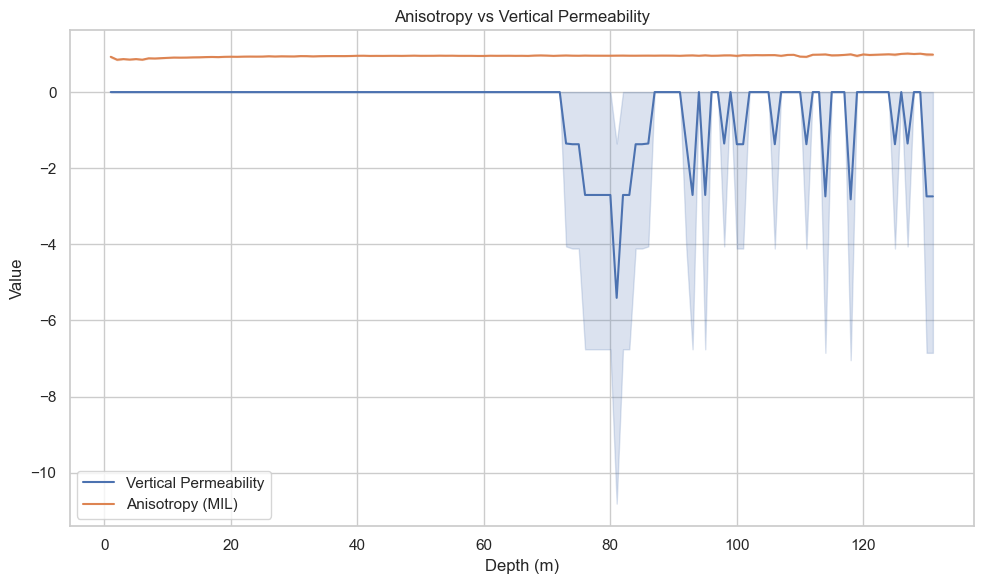

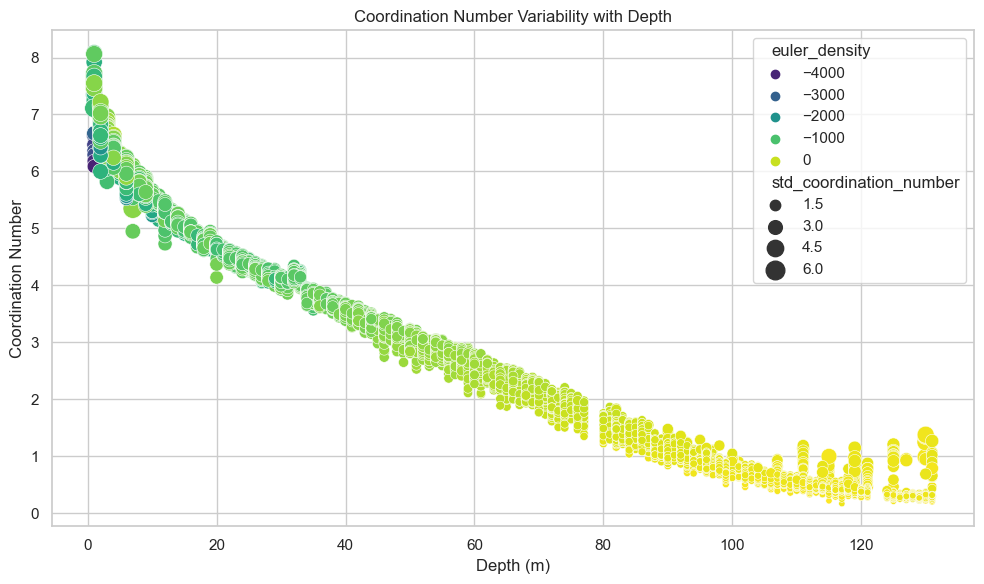

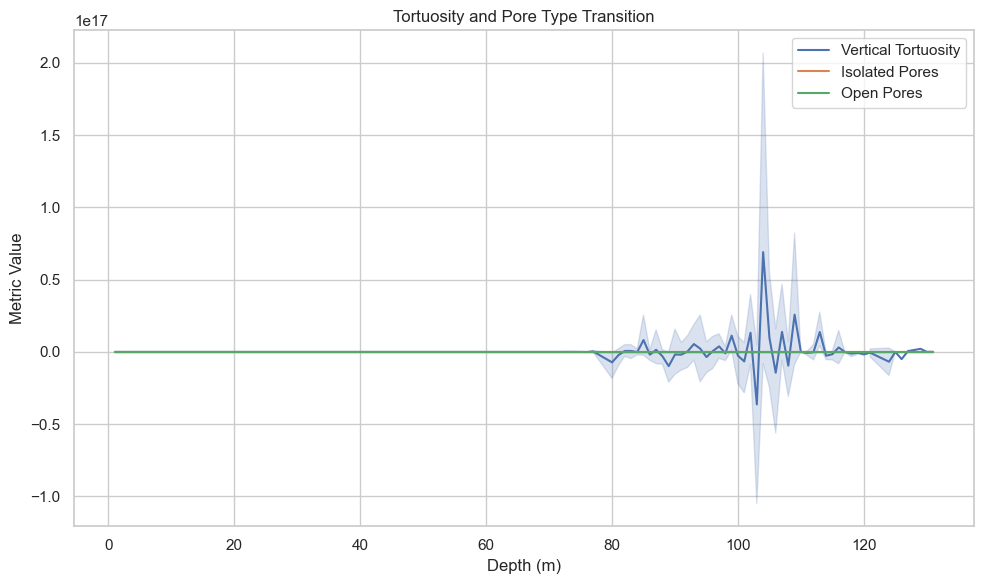

C:\Users\Faramarz\AppData\Local\Temp\ipykernel_10512\3698140174.py:56: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged = df.groupby(pd.cut(df['depth'], bins=depth_bins)).mean()


In [5]:

import plotly.express as px



# Set seaborn theme
sns.set(style="whitegrid")

# HYPOTHESIS 1: Cluster-Based Densification Dynamics
plt.figure(figsize=(10, 6))
sns.lineplot(x="depth", y="cluster_density", label="Cluster Density", data=df)
sns.lineplot(x="depth", y="avg_cluster_size", label="Avg Cluster Size", data=df)
plt.title("Cluster Evolution vs Depth")
plt.xlabel("Depth (m)")
plt.ylabel("Cluster Metrics")
plt.legend()
plt.tight_layout()
plt.show()

# HYPOTHESIS 2: Anisotropy-Controlled Permeability Evolution
plt.figure(figsize=(10, 6))
sns.lineplot(x="depth", y="Perm_z", label="Vertical Permeability", data=df)
sns.lineplot(x="depth", y="anisotropy_MIL", label="Anisotropy (MIL)", data=df)
plt.title("Anisotropy vs Vertical Permeability")
plt.xlabel("Depth (m)")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# HYPOTHESIS 3: Coordination Number and Collapse Indicators
plt.figure(figsize=(10, 6))
sns.scatterplot(x="depth", y="coordination_number", size="std_coordination_number", hue="euler_density", data=df, palette="viridis", sizes=(20, 200))
plt.title("Coordination Number Variability with Depth")
plt.xlabel("Depth (m)")
plt.ylabel("Coordination Number")
plt.tight_layout()
plt.show()

# HYPOTHESIS 4: Tortuosity vs Pore Isolation
plt.figure(figsize=(10, 6))
sns.lineplot(x="depth", y="Tort_z", label="Vertical Tortuosity", data=df)
sns.lineplot(x="depth", y="isolated_pores", label="Isolated Pores", data=df)
sns.lineplot(x="depth", y="open_pores", label="Open Pores", data=df)
plt.title("Tortuosity and Pore Type Transition")
plt.xlabel("Depth (m)")
plt.ylabel("Metric Value")
plt.legend()
plt.tight_layout()
plt.show()

# HYPOTHESIS 5: Multivariate Fingerprinting (PCA-style proxy with radar plot)
import plotly.graph_objects as go

def radar_plot(df, depth_bins):
    averaged = df.groupby(pd.cut(df['depth'], bins=depth_bins)).mean()
    parameters = ['porosity', 'SSA', 'euler_density', 'avg_pore_surface_area', 'avg_pore_diameter', 'avg_throat_diameter']
    
    fig = go.Figure()
    for idx, row in averaged.iterrows():
        fig.add_trace(go.Scatterpolar(
            r=[row[p] for p in parameters],
            theta=parameters,
            fill='toself',
            name=f"{idx}"
        ))
    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True)),
        title="Radar Plot of Microstructural Fingerprint by Depth Bin",
        showlegend=True
    )
    fig.show()

# Define depth bins and call radar plot
depth_bins = [0, 10, 20, 30, 40, 50]
radar_plot(df, depth_bins)


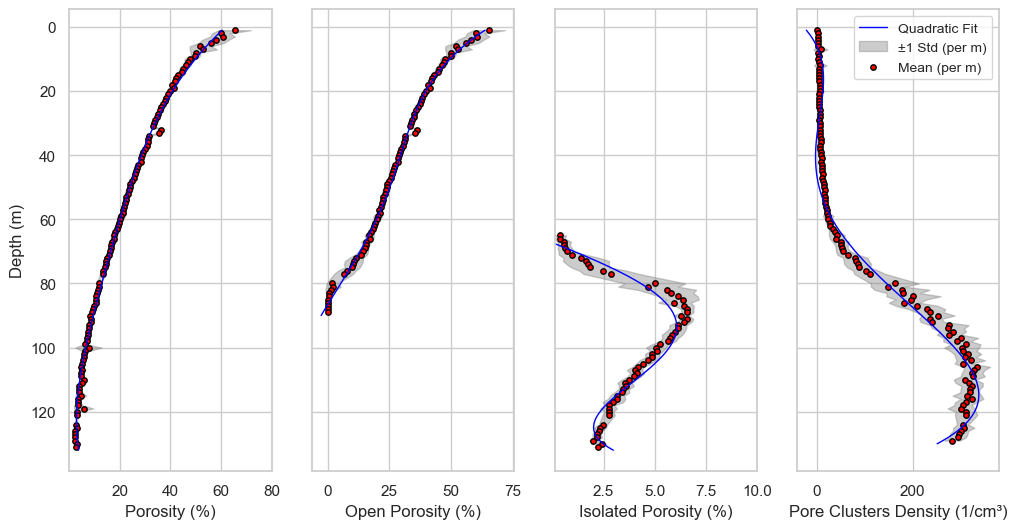

In [6]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()

# Sort data by depth for smooth plotting
df = data.sort_values(by="new_depth").copy()

# Create figure with shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("porosity", "Porosity (%)"),
    ("open_pores", "Open Porosity (%)"),
    ("isolated_pores", "Isolated Porosity (%)"),
    ('cluster_density','Pore Clusters Density (1/cm³)')
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):
    x = df[col]
    y = depth

    if col == "open_pores":
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 90].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]

    elif col == 'isolated_pores':
        # Subset for depth >= 50
        df_fit = df[df["new_depth"]>65].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        ax.set_xlim(0.1, 10)

    elif col == "cluster_density":
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 130].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        #ax.set_xlim(0.1, 200)
        
    else:
        x = df[col]
        y = depth
        ax.set_xlim(-2, 75)
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]
        ax.set_xlim(0.1, 80)
    
    # Residuals and std
    #residuals = x_fit_data - poly(y_fit_data)
    #std = np.std(residuals)
    #ax.fill_betweenx(y_fit, x_fit - std, x_fit + std, color='gray', alpha=0.4, label='±1 Std Dev')

    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

        
        # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
        # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='blue', linewidth=1, label='Quadratic Fit')
        # Plot ± std dev band around the bin means
    ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

plt.legend(loc='upper right', fontsize=10)
# Layout adjustments
#plt.tight_layout()
plt.savefig("fig_porosity.png", dpi=600, bbox_inches='tight')
plt.show()

In [7]:
df.columns

Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'anisotropy_MIL', 'depth_bin'],
      dtype='object')

sph_ice_cluster
euler_density
SSA
anisotropy_MIL


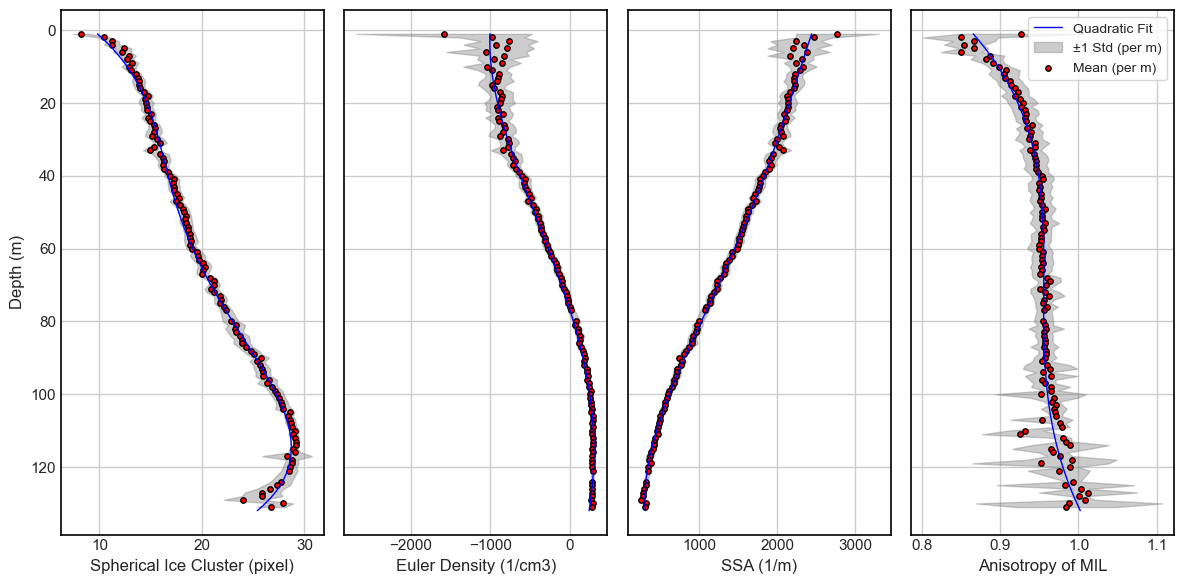

In [7]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()

# Sort data by depth for smooth plotting
df = df.sort_values(by="new_depth")

# Create figure with shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("sph_ice_cluster", "Spherical Ice Cluster (pixel)"),
    ("euler_density", "Euler Density (1/cm3)"),
    ("SSA", "SSA (1/m)"),
    ("anisotropy_MIL", "Anisotropy of MIL")
]


for ax, (col, xlabel) in zip(axes, params):
    print (col)
    x = df[col]
    y = df["new_depth"]
    
    df["depth_bin"] = df["new_depth"].astype(int)
    grouped = df.groupby("depth_bin")[col]

    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

        
        # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
        # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='blue', linewidth=1, label='Quadratic Fit')
        # Plot ± std dev band around the bin means
    ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    

    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

# Layout adjustments
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig("fig_SIC_SSA_Euler.png", dpi=600, bbox_inches='tight')
plt.show()

In [8]:
df.columns

Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'anisotropy_MIL', 'depth_bin'],
      dtype='object')

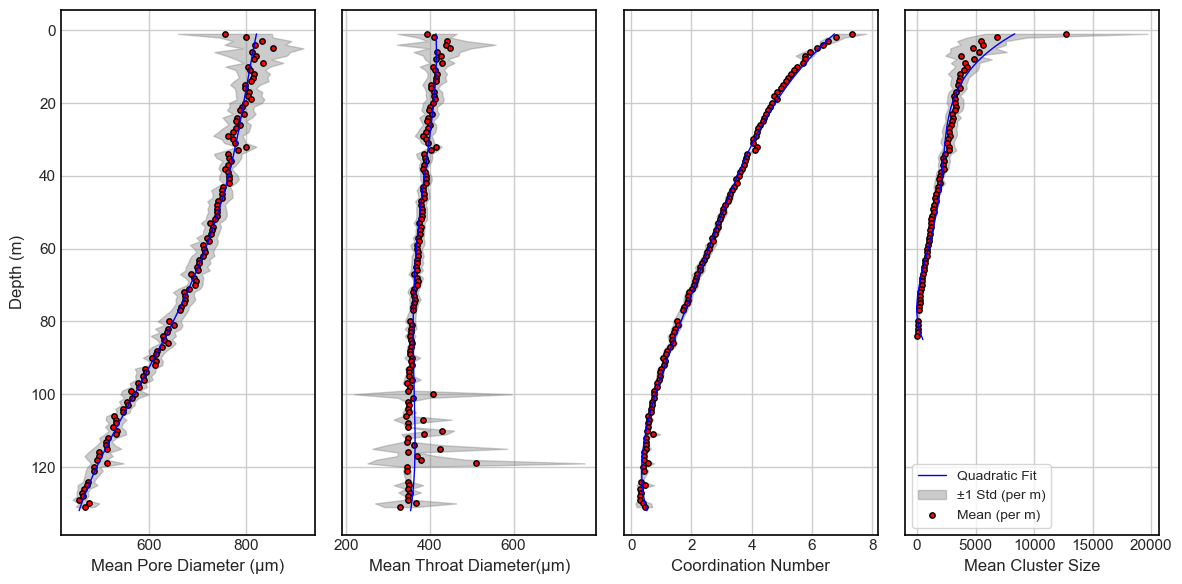

In [9]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()

# Sort data by depth for smooth plotting
df = df.sort_values(by="new_depth")

# Create figure with shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("avg_pore_diameter", "Mean Pore Diameter (μm)"),
    ("avg_throat_diameter", "Mean Throat Diameter(μm)"),
    ("coordination_number", "Coordination Number"),
    ("avg_cluster_size", "Mean Cluster Size")
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):

    
    if col == "avg_cluster_size":
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 85].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
    else:
        x = df[col]
        y = df["new_depth"]
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]

    
    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

            # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
            # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='blue', linewidth=1, label='Quadratic Fit')
            # Plot ± std dev band around the bin means
    ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

# Layout adjustments
plt.legend(loc='lower left', fontsize=10)

plt.tight_layout()
plt.savefig("fig_network.png", dpi=600, bbox_inches='tight')
plt.show()

In [33]:
df.columns

Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'anisotropy_MIL', 'anisotropy_Perm',
       'anisotropy_Tort'],
      dtype='object')

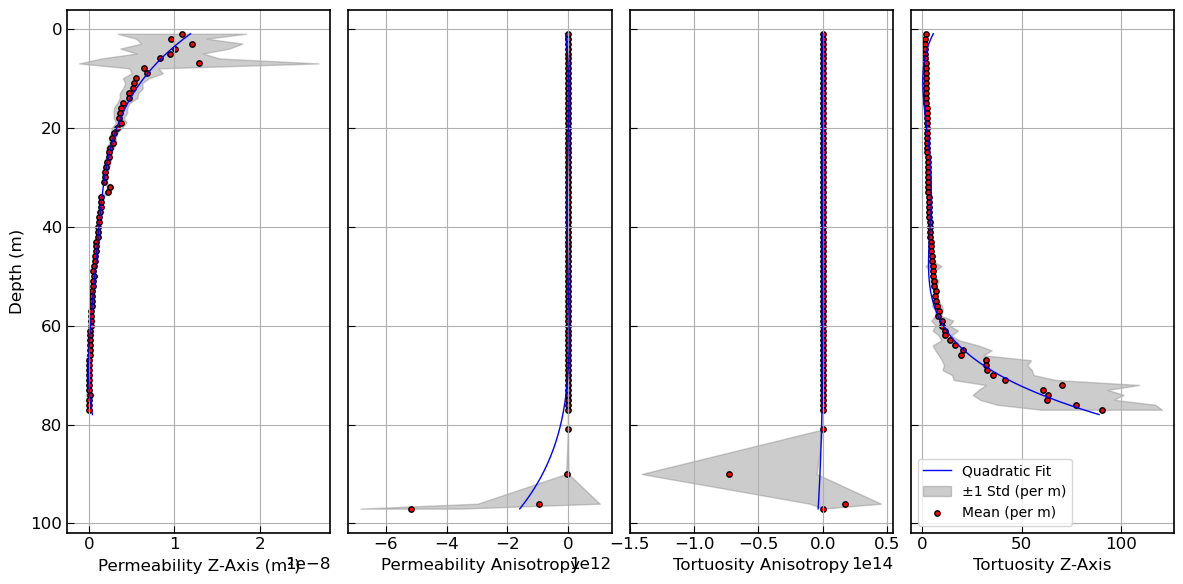

In [36]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()


# Create figure with shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("Perm_z", "Permeability Z-Axis (m²)"),
    ("anisotropy_Perm", "Permeability Anisotropy"),
    ("anisotropy_Tort", "Tortuosity Anisotropy"),
    ("Tort_z", "Tortuosity Z-Axis")
    
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):

    
    if col == "Tort_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        #df = df[df["new_depth"] < 90]
        df = df[df["new_depth"] < 100]
        df = df[df["Tort_z"] > 1]
        df = df[df["Tort_z"] < 150]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 80].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
        
        
    elif col == "Perm_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        #df = df[df["new_depth"] < 90]
        df = df[df["new_depth"] < 100]
        df = df[df["Perm_z"] > 5e-12]
        df = df[df["Perm_z"] < 5e-8]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 80].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
    else:
        x = df[col]
        y = df["new_depth"]
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]

    
    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

            # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
            # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='blue', linewidth=1, label='Quadratic Fit')
            # Plot ± std dev band around the bin means
    ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

# Layout adjustments
plt.legend(loc='lower left', fontsize=10)

plt.tight_layout()
plt.savefig("fig_transport.png", dpi=600, bbox_inches='tight')
plt.show()

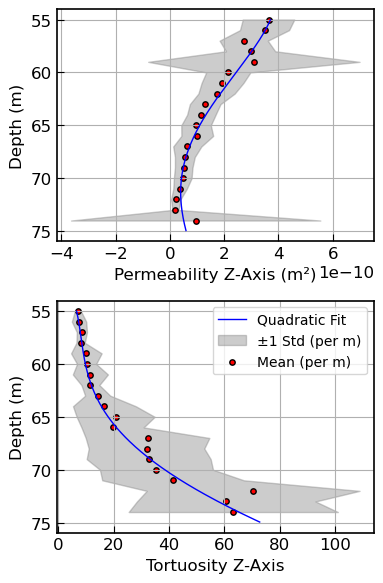

In [43]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()


# Create figure with shared y-axis
#fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharey=True)
fig, axes = plt.subplots(2, 1, figsize=(4, 6))
# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("Perm_z", "Permeability Z-Axis (m²)"),
    ("Tort_z", "Tortuosity Z-Axis")
    
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):

    
    if col == "Tort_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        df = df[df["new_depth"] < 75]
        df = df[df["new_depth"] > 55]
        df = df[df["Tort_z"] > 1]
        df = df[df["Tort_z"] < 150]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] > 55].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
        
        
    elif col == "Perm_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        df = df[df["new_depth"] < 75]
        df = df[df["new_depth"] > 55]
        
        df = df[df["Perm_z"] > 5e-12]
        df = df[df["Perm_z"] < 5e-8]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] > 55].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
    else:
        x = df[col]
        y = df["new_depth"]
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]

    
    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

            # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
            # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='blue', linewidth=1, label='Quadratic Fit')
            # Plot ± std dev band around the bin means
    ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[1].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward
axes[1].invert_yaxis()
# Layout adjustments
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig("fig_transport_zoom.png", dpi=600, bbox_inches='tight')
plt.show()

In [5]:
df = data.copy()
df.columns

Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'anisotropy_MIL', 'anisotropy_Perm',
       'anisotropy_Tort', 'density'],
      dtype='object')

In [ ]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()


# Create figure with shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("Perm_z", "Permeability Z-Axis (m²)"),
    ("anisotropy_Perm", "Permeability Anisotropy"),
    ("anisotropy_Tort", "Tortuosity Anisotropy"),
    ("Tort_z", "Tortuosity Z-Axis")
    
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):

    
    if col == "Tort_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        #df = df[df["new_depth"] < 90]
        df = df[df["new_depth"] < 100]
        df = df[df["Tort_z"] > 1]
        df = df[df["Tort_z"] < 150]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 80].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
        
        
    elif col == "Perm_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        #df = df[df["new_depth"] < 90]
        df = df[df["new_depth"] < 100]
        df = df[df["Perm_z"] > 5e-12]
        df = df[df["Perm_z"] < 5e-8]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 80].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
    else:
        x = df[col]
        y = df["new_depth"]
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]

    
    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

            # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
            # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='blue', linewidth=1, label='Quadratic Fit')
            # Plot ± std dev band around the bin means
    ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

# Layout adjustments
plt.legend(loc='lower left', fontsize=10)

plt.tight_layout()
plt.savefig("fig_transport.png", dpi=600, bbox_inches='tight')
plt.show()

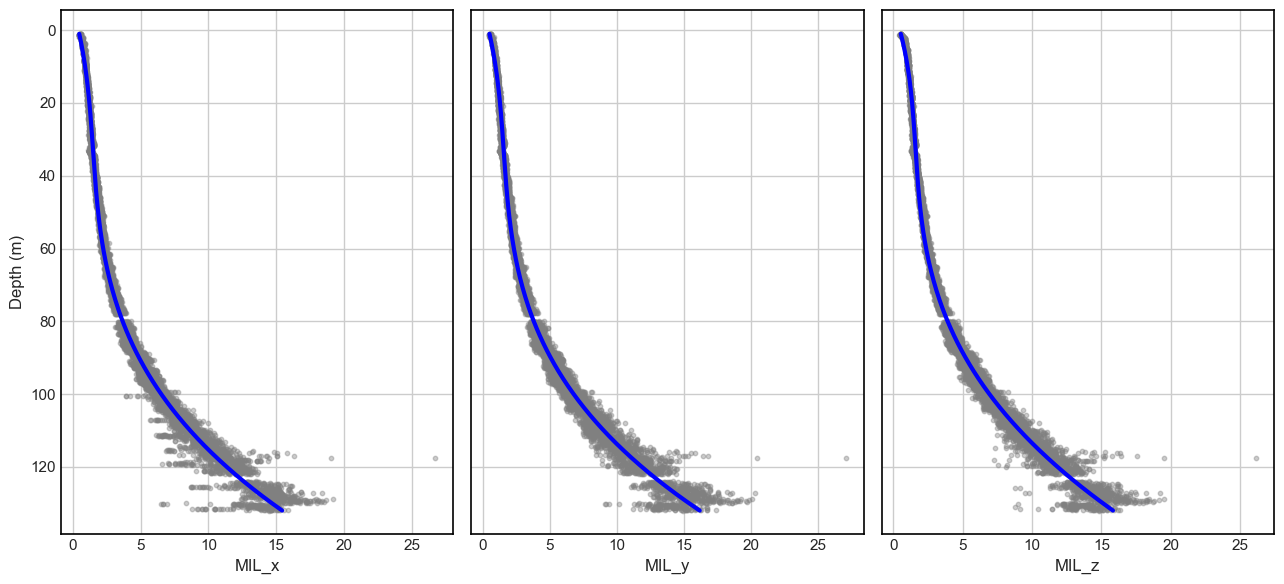

In [12]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()

# Sort data by depth for smooth plotting
df = df.sort_values(by="new_depth")

# Create figure with shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(13, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})
'MIL_x', 'MIL_y', 'MIL_z'
# Plot configs
params = [
    ("MIL_x", "MIL_x"),
    ("MIL_y", "MIL_y"),
    ("MIL_z", "MIL_z")
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):
    x = df[col]
    y = depth
    
    # Scatter plot
    ax.scatter(x, y, color='gray', alpha=0.4, s=10, label='Data')

        # Trend line
    if col == "open_pores":
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 90]
        y_fit_data = df_fit["new_depth"]
        x_fit_data = df_fit[col]
        # Fit quadratic
        coeffs = np.polyfit(y_fit_data, x_fit_data, deg=3)
        poly = np.poly1d(coeffs)
        # Generate smooth depth range from 50 to max
        y_fit = np.linspace(y_fit_data.min(), y_fit_data.max(), 200)
        x_fit = poly(y_fit)
        ax.plot(x_fit, y_fit, color='blue', linewidth=3, label='Quadratic Fit (depth ≥ 50)')
        ax.set_xlim(-2, 100)
        
    elif col == 'isolated_pores':
        df_fit = df[df["new_depth"] >= 65]
        y_fit_data = df_fit["new_depth"]
        x_fit_data = df_fit[col]
        
        # Fit quadratic
        coeffs = np.polyfit(y_fit_data, x_fit_data, deg=3)
        poly = np.poly1d(coeffs)

        # Generate smooth depth range from 50 to max
        y_fit = np.linspace(y_fit_data.min(),  y_fit_data.max(), 200)
        x_fit = poly(y_fit)
        ax.plot(x_fit, y_fit, color='blue', linewidth=3, label='Quadratic Fit (depth ≥ 50)')
        #ax.set_xlim(-0.1, 10)
    else:
        # Quadratic fit
        coeffs = np.polyfit(x=y, y=x, deg=4)        # x vs depth (i.e., x = f(y))
        poly = np.poly1d(coeffs)
        y_fit = np.linspace(y.min(), y.max(), 200)  # Smooth y values
        x_fit = poly(y_fit)
    
    # Plot trend line
        ax.plot(x_fit, y_fit, color='blue', linewidth=3, label='Quadratic Fit')
        #ax.set_xlim(-2, 100)
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

# Layout adjustments
plt.tight_layout()
plt.savefig("MIL.png", dpi=600, bbox_inches='tight')
plt.show()

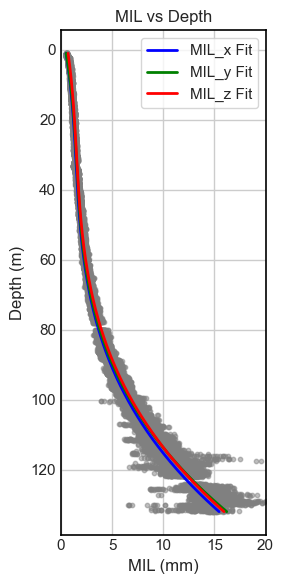

In [13]:
fig, ax = plt.subplots(figsize=(3, 6))

for mil_col, label, color in [("MIL_x", "MIL_x", 'blue'), 
                              ("MIL_y", "MIL_y", 'green'), 
                              ("MIL_z", "MIL_z", 'red')]:
    x = df["new_depth"]
    y = df[mil_col]
    
    # Scatter
    ax.scatter( y, x,color='gray', s=10, alpha=0.5)

    # Fit and plot quadratic trend
    coeffs = np.polyfit(x, y, deg=3)
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(x.min(), x.max(), 300)
    y_fit = poly(x_fit)
    ax.plot( y_fit,x_fit, color=color, linewidth=2, label=f'{label} Fit')

# Style
ax.set_xlabel("MIL (mm)")
ax.set_ylabel("Depth (m)")
ax.set_title("MIL vs Depth")
ax.grid(True)
ax.legend()
ax.invert_yaxis()  # Optional: reverse depth direction
ax.set_xlim(0, 20)  # Optional
# ax.set_ylim(0, 5)    # Optional

plt.tight_layout()
plt.savefig("MIL_vs_depth.png", dpi=600, bbox_inches='tight')
plt.show()


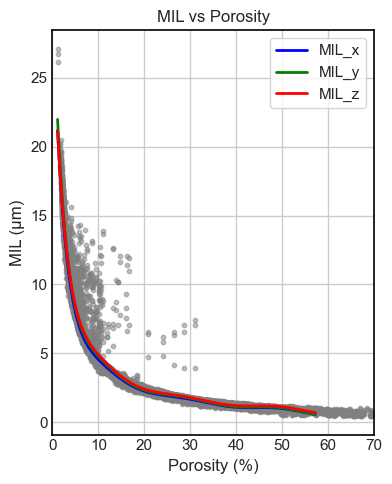

In [14]:
fig, ax = plt.subplots(figsize=(4, 5))

for mil_col, label, color in [("MIL_x", "MIL_x", 'blue'), 
                              ("MIL_y", "MIL_y", 'green'), 
                              ("MIL_z", "MIL_z", 'red')]:
    
    # Full scatter
    ax.scatter(df["porosity"], df[mil_col], color='gray', s=10, alpha=0.5)
    
    # Subset data for trend line (porosity < 60)
    mask = df["porosity"] < 100
    x_fit_data = df.loc[mask, "porosity"]
    y_fit_data = df.loc[mask, mil_col]
    
    # Fit and plot quadratic trend line
    coeffs = np.polyfit(x_fit_data, y_fit_data, deg=10)
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(x_fit_data.min(), x_fit_data.max(), 300)
    y_fit = poly(x_fit)

    ax.plot(x_fit[:220], y_fit[:220], color=color, linewidth=2, label=f'{label}')

# Formatting
ax.set_xlabel("Porosity (%)")
ax.set_ylabel("MIL (µm)")
ax.set_title("MIL vs Porosity")
ax.grid(True)
ax.legend()
ax.set_xlim(0, 70)   # Full porosity range for scatter
# ax.set_ylim(0, 5)    # Optional y-limit

plt.tight_layout()
plt.savefig("MIL_vs_porosity_limited_fit.png", dpi=600, bbox_inches='tight')
plt.show()


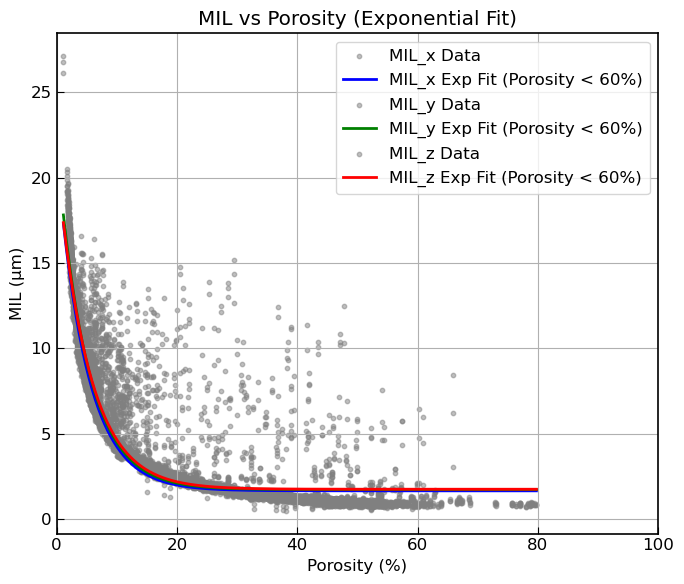

In [100]:

# Define offset exponential function
def exp_offset(x, a, b, c):
    return a * np.exp(b * x) + c
    
# Start plotting
fig, ax = plt.subplots(figsize=(7, 6))

for mil_col, label, color in [("MIL_x", "MIL_x", 'blue'), 
                              ("MIL_y", "MIL_y", 'green'), 
                              ("MIL_z", "MIL_z", 'red')]:
    
    # Full scatter plot
    ax.scatter(df["porosity"], df[mil_col], color='gray', s=10, alpha=0.5, label=f'{label} Data')

    # Subset for porosity < 60
    mask = df["porosity"] < 100
    x_data = df.loc[mask, "porosity"]
    y_data = df.loc[mask, mil_col]
    
    try:
        popt, _ = curve_fit(exp_offset, x_data, y_data, p0=(1, 0.01, 0), maxfev=10000)
        x_fit = np.linspace(x_data.min(), x_data.max(), 300)
        y_fit = exp_offset(x_fit, *popt)
        ax.plot(x_fit, y_fit, color=color, linewidth=2, label=f'{label} Exp Fit (Porosity < 60%)')
    except RuntimeError:
        print(f"Could not fit exponential with offset for {label}")

# Final formatting
ax.set_xlabel("Porosity (%)")
ax.set_ylabel("MIL (µm)")
ax.set_title("MIL vs Porosity (Exponential Fit)")
ax.grid(True)
ax.legend()
ax.set_xlim(0, 100)  # Full porosity range
# ax.set_ylim(0, 5)  # Optional

plt.tight_layout()
#plt.savefig("MIL_vs_porosity_exponential_fit.png", dpi=600, bbox_inches='tight')
plt.show()
